In [1]:
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input
from tensorflow.keras.metrics import Precision, Recall

In [2]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [3]:
inception = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),include_top=False,weights='imagenet')

In [4]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
count = 0
for layer in inception.layers:
    count += 1

In [6]:
count

311

In [7]:
x = inception.get_layer('conv2d_60').output
x

<tf.Tensor 'conv2d_60/Conv2D:0' shape=(None, 12, 12, 192) dtype=float32>

In [8]:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [9]:
model = Model(inputs=inception.input, outputs=output)

In [10]:
count = 0
for layer in model.layers:
    count += 1

In [11]:
count

201

In [12]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=20,
          verbose=2
)

Epoch 1/20
29/29 - 4s - loss: 0.7198 - accuracy: 0.5445 - val_loss: 0.5794 - val_accuracy: 0.6269
Epoch 2/20
29/29 - 3s - loss: 0.5977 - accuracy: 0.6797 - val_loss: 0.4995 - val_accuracy: 0.6866
Epoch 3/20
29/29 - 4s - loss: 0.5126 - accuracy: 0.7687 - val_loss: 0.4413 - val_accuracy: 0.9254
Epoch 4/20
29/29 - 3s - loss: 0.4603 - accuracy: 0.8505 - val_loss: 0.3919 - val_accuracy: 0.9403
Epoch 5/20
29/29 - 3s - loss: 0.4190 - accuracy: 0.8861 - val_loss: 0.3523 - val_accuracy: 0.9403
Epoch 6/20
29/29 - 4s - loss: 0.3729 - accuracy: 0.9181 - val_loss: 0.3214 - val_accuracy: 0.9552
Epoch 7/20
29/29 - 3s - loss: 0.3406 - accuracy: 0.9217 - val_loss: 0.2911 - val_accuracy: 0.9552
Epoch 8/20
29/29 - 3s - loss: 0.2980 - accuracy: 0.9502 - val_loss: 0.2679 - val_accuracy: 0.9552
Epoch 9/20
29/29 - 3s - loss: 0.2879 - accuracy: 0.9644 - val_loss: 0.2479 - val_accuracy: 0.9552
Epoch 10/20
29/29 - 3s - loss: 0.2485 - accuracy: 0.9573 - val_loss: 0.2384 - val_accuracy: 0.9552
Epoch 11/20
29/29 -

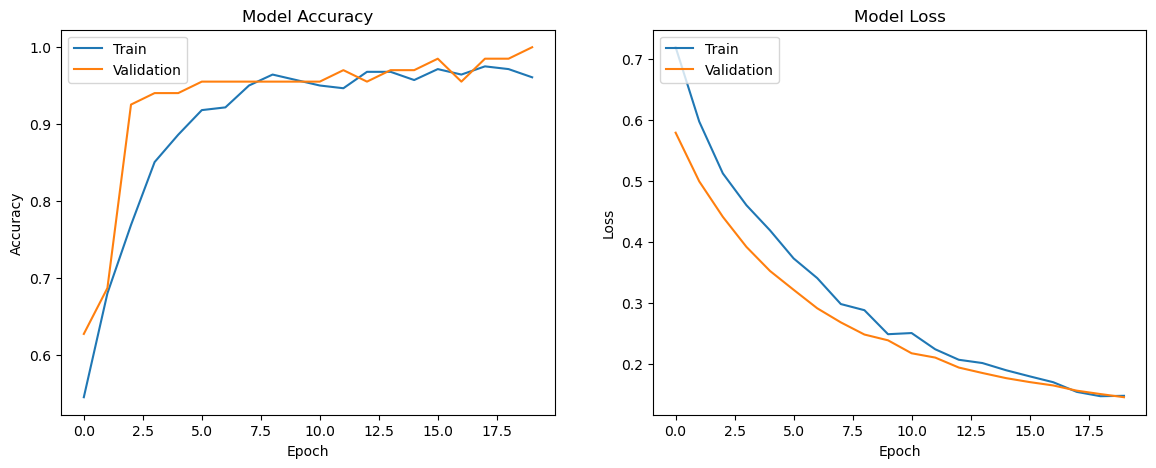

In [15]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [16]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.96
F1 Score:  0.9795918367346939
Accuracy:  0.9850746268656716
